# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any consumer suitability or choke hazard concerns?' , based on the Input Data
# It does vectorization of each Column and concatenates these Vectors to create a final Feature Vector and fits the best ML Model found from benchmarking study

In [247]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

In [248]:
tf.__version__

'1.14.0'

In [249]:
import sklearn
print(sklearn.__version__)

0.19.0


## File name and other important parameters like ngram_range set

In [250]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"

In [251]:
filename1 = "C:/Pepsico/choke hazards_08 26.xlsm"

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) 

In [252]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from','dtype','object']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

In [253]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [254]:
def clean_doc(corpus):
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
	# split into tokens by white space
        doc=str(doc)
        doc = doc.replace('\n',' ')
        tokens = doc.split()
        # prepare regex for char filtering
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        # remove punctuation from each word
        tokens = [re_punc.sub('', w) for w in tokens]
        # remove remaining tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]
        # filter out stop words
        tokens = [w for w in tokens if not w in stop_words]
        # filter out short tokens
        tokens = [word for word in tokens if len(word) > 1]
        # remove nn from each word
        tokens = [re.sub('nn',' ',word) for word in tokens]
        tokens = ' '.join(tokens)
        normalized_corpus.append(tokens)
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [255]:
fsha_data = pd.read_excel(filename)

In [256]:
len(fsha_data)

209

In [257]:
fsha_data = fsha_data[(fsha_data['chokeHazard']=='No')]

In [258]:
len(fsha_data)

204

In [259]:
fsha_data_yes = pd.read_excel(filename1)

In [260]:
len(fsha_data_yes)

25

In [261]:
fsha_data = pd.concat([fsha_data,fsha_data_yes])

In [262]:
len(fsha_data)

229

In [263]:
fsha_data.head()

,CPD-ProdName,CPD-ProdName-Desc,Current TSG Stage,FSAssessors,FSDate,File Name,PDA_projName,PlantTrial,TCG,Table1_Row1_Celery,...,prodModifications,prodStorageDist,projDesc,projName,projType,sector,shelfLife,specificStorage,targetMarket,waterActivity
0,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,"Extruded and baked corn base product, flavoure...",G3,Helen Booden,21/11/2017,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,"Tomaszow plant, trial conducted on 02/11/2017","Families and Adults, value conscious consumers",0,...,No,"Store in a dry, cool and away from sun place.",Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,Brand Refresh,ESSA,26 weeks,No,"People with allergies to milk, lactose, peanuts.",low moisture food
1,Hrusteam,Crispy Bread,"Gate 3, 4",Fedor Kholodov,2019-06-14 00:00:00,#53697 FSHA HT Baguette 4 Cheese UA 2.07.19.xlsm,Hrusteam Baguette,Nikolaev,Adults,0,...,No,"Keep at temperature 25 °C, <75% humidity",Launch new seasoning 4 Cheese NL-502-352-9 on ...,HT Baguette Four Cheese Flavor,Refresh,ESSA,140 days,"Keep at temperature 25 °C, <75% humidity",No,low water activity
2,Lay's Red Caviar,Potato chips,Development + Scale-up,Helen Booden,2019-06-27 00:00:00,#57686 FSHA 5.4.1 Red Caviar Azov.xlsm,Lay's Red Caviar,"Azov, Russia",18-45 y.o. males 50%/females 50%,0,...,No,air temperature is not higher than 25 ˚С and r...,Idea is to launch I&O flavour under New Year p...,Lay's Caviar IO 2019 RUS Asov,Refresh,ESSA,20+1 week,store the product for no more than 24 hours at...,people with allergy to ingredients in the prod...,Low water activity
3,Lay's Red Caviar,Potato chips,Development + Scale-up,Helen Booden,2019-06-27 00:00:00,#57686 FSHA 5.4.1 Red Caviar Kashira.xlsm,Lay's Red Caviar,"Kashira, Russia",18-45 y.o. males 50%/females 50%,0,...,No,air temperature is not higher than 25 ˚С and r...,Idea is to launch I&O flavour under New Year p...,Lay's Caviar IO 2019 RUS Kashira,Refresh,ESSA,20+1 week,store the product for no more than 24 hours at...,people with allergy to ingredients in the prod...,Low water activity
4,Cheetos Palomitos,"Extruded product with ""popcorn"" shape with cre...",G3 4 Combined,Helen Booden,2018-11-28 00:00:00,53354-FSHA-In Process 13.12.18.xlsm,Cheetos Palomito,"Burgos, Spain",Kids and families,0,...,No,"Product to be sold in Iberia, storage in ambie...","Re Launch of Cheetos Palomitos, Soft Extruded ...",Soft and Mild Iberia 2019,Re Launch,ESSA,Flavour/color loss powered by clear film windo...,Ensure the bag is closed and consumed after 2 ...,Kids from 4-10,Low water activity


# Based on Analysis select the Features (X)

In [264]:
#selecting set of columns as Features
fsha_data.fillna('NA', inplace=True)
features_df=fsha_data[['projDesc','PDA_projName','packMaterial', 'CPD-ProdName','CPD-ProdName-Desc','TCG', 'labelingInstructions',
        'mishandled', 'targetMarket']]

In [265]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))  
features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName']=features_df['CPD-ProdName'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['TCG']=features_df['TCG'].apply(lambda x:conv_str(x)) 
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x)) 
features_df['mishandled']=features_df['mishandled'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x)) 

# Replace missing values in features with NA

In [266]:
train_df = features_df

# Define reusable code to Vectorize Text column (ex: Project Description) using TF-IDF Vectorizer, after doing Text data normalization

In [267]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500
ngram_range = n_gram_range
n_gram_range = (1,2)
kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
vectorizer = TfidfVectorizer(**kwargs)

def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    x_train = x_train.astype('float32')
    return x_train

In [268]:
train_df.columns

Index(['projDesc', 'PDA_projName', 'packMaterial', 'CPD-ProdName',
       'CPD-ProdName-Desc', 'TCG', 'labelingInstructions', 'mishandled',
       'targetMarket'],
      dtype='object')

# Normalize each column , by cleaning the text

In [269]:
#train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
#train_df['norm_allergens_M']=normalize_corpus(train_df['allergensLabeledIMAF'])



train_df['projDesc']=normalize_corpus(train_df['projDesc'])
train_df['PDA_projName']=normalize_corpus(train_df['PDA_projName'])
train_df['packMaterial']=normalize_corpus(train_df['packMaterial'])  
train_df['CPD-ProdName']=normalize_corpus(train_df['CPD-ProdName'])  
train_df['CPD-ProdName-Desc']=normalize_corpus(train_df['CPD-ProdName-Desc'])
train_df['TCG']=normalize_corpus(train_df['TCG']) 
train_df['labelingInstructions']=normalize_corpus(train_df['labelingInstructions']) 
train_df['mishandled']=normalize_corpus(train_df['mishandled']) 
train_df['targetMarket']=normalize_corpus(train_df['targetMarket'])

In [270]:
train_df.columns

Index(['projDesc', 'PDA_projName', 'packMaterial', 'CPD-ProdName',
       'CPD-ProdName-Desc', 'TCG', 'labelingInstructions', 'mishandled',
       'targetMarket'],
      dtype='object')

# Binarize the target (1/0 for Yes/No)

In [271]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Target (Yes/No choice) in PDAF are converted to binary values

In [272]:
train_y_chokehazard = impute_target(fsha_data,"chokeHazard")

In [273]:
train_df['target']=train_y_chokehazard

In [274]:
train_df['target'].value_counts()

0    204
1     25
Name: target, dtype: int64

In [275]:
y = train_df['target']
train_df = train_df.drop('target',axis=1)

# Perform n-gram vectorization and PCA on text data, columnwise, and concatenate (6 components per column)

In [276]:
n_gram_range = (1,2)
n_components = 6
whiten = False
random_state = 42
svd_solver="full"
pca = PCA(n_components=n_components,svd_solver=svd_solver,whiten=whiten, random_state=42)
scaler = StandardScaler()

def preprocess_text(train_df,y):    
    train_labels = y
    #x_ngram_allergens = ngram_vectorize(train_df['norm_allergens'], train_labels,n_gram_range).toarray()
    #x_ngram_allergens_m = ngram_vectorize(train_df['norm_allergens_M'], train_labels,n_gram_range).toarray()
    x_ngram_projDesc=ngram_vectorize(train_df['projDesc'], train_labels,n_gram_range).toarray()
    x_ngram_PDA_projName=ngram_vectorize(train_df['PDA_projName'], train_labels,n_gram_range).toarray()
    x_ngram_packMaterial=ngram_vectorize(train_df['packMaterial'], train_labels,n_gram_range).toarray() 
    x_ngram_CPD_ProdName=ngram_vectorize(train_df['CPD-ProdName'], train_labels,n_gram_range).toarray() 
    x_ngram_CPD_ProdName_Desc=ngram_vectorize(train_df['CPD-ProdName-Desc'], train_labels,n_gram_range).toarray()
    x_ngram_TCG=ngram_vectorize(train_df['TCG'], train_labels,n_gram_range).toarray() 
    x_ngram_labelingInstructions=ngram_vectorize(train_df['labelingInstructions'], train_labels,n_gram_range).toarray()
    x_ngram_mishandled=ngram_vectorize(train_df['mishandled'], train_labels,n_gram_range).toarray() 
    x_ngram_targetMarket=ngram_vectorize(train_df['targetMarket'], train_labels,n_gram_range).toarray()
    train_df = train_df.drop(['projDesc','PDA_projName','packMaterial','CPD-ProdName','TCG','labelingInstructions','mishandled','targetMarket'],axis=1)
    
    
    
    x_ngram_projDesc = scaler.fit_transform(x_ngram_projDesc)
    x_ngram_PDA_projName = scaler.fit_transform(x_ngram_PDA_projName)
    x_ngram_packMaterial = scaler.fit_transform(x_ngram_packMaterial)
    x_ngram_CPD_ProdName = scaler.fit_transform(x_ngram_CPD_ProdName)
    x_ngram_CPD_ProdName_Desc = scaler.fit_transform(x_ngram_CPD_ProdName_Desc)
    x_ngram_TCG = scaler.fit_transform(x_ngram_TCG)
    x_ngram_labelingInstructions = scaler.fit_transform(x_ngram_labelingInstructions)
    x_ngram_mishandled = scaler.fit_transform(x_ngram_mishandled)
    x_ngram_targetMarket = scaler.fit_transform(x_ngram_targetMarket)
    
    x_pca_projDesc = pca.fit_transform(x_ngram_projDesc)
    x_pca_PDA_projName = pca.fit_transform(x_ngram_PDA_projName)
    x_pca_packMaterial = pca.fit_transform(x_ngram_packMaterial)
    x_pca_CPD_ProdName = pca.fit_transform(x_ngram_CPD_ProdName)
    x_pca_CPD_ProdName_Desc = pca.fit_transform(x_ngram_CPD_ProdName_Desc)
    x_pca_TCG = pca.fit_transform(x_ngram_TCG)
    x_pca_labelingInstructions = pca.fit_transform(x_ngram_labelingInstructions)
    x_pca_mishandled = pca.fit_transform(x_ngram_mishandled)
    x_pca_targetMarket = pca.fit_transform(x_ngram_targetMarket)
    #x_pca_allergens_m = pca.fit_transform(x_ngram_allergens_m)
    #print(x_pca_allergens.shape)
    #print(x_pca_allergens_m.shape)
    x_train = np.concatenate((x_pca_projDesc,x_pca_PDA_projName,x_pca_packMaterial,x_pca_CPD_ProdName,x_pca_CPD_ProdName_Desc,x_pca_TCG,x_pca_labelingInstructions,x_pca_mishandled,x_pca_targetMarket),axis=1)
    print(x_train.shape)
    return x_train  

In [277]:
from sklearn.externals import joblib
X_features = preprocess_text(train_df,y)
joblib.dump(scaler, "scaler_chokehazard.pkl")
joblib.dump(pca, "pca_chokehazard.pkl")
joblib.dump(vectorizer,"vectorizer_chokehazard.pkl")

(229, 54)


['vectorizer_chokehazard.pkl']

In [278]:
y.shape

(229,)

# Perform train test split

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=.2, random_state=42,stratify = y)

In [280]:
print(X_train.shape)
print(X_test.shape)

(183, 54)
(46, 54)


In [281]:
print(y_train.shape)
print(y_test.shape)

(183,)
(46,)


In [282]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [283]:
print(y_train.shape)
print(y_test.shape)

(183, 1)
(46,)


In [284]:
#X_train.columns = ['PCA_allergens_1','PCA_allergens_2','PCA_allergens_3','PCA_allergens_4','PCA_allergens_5','PCA_allergens_6','PCA_allergens_M_1','PCA_allergens_M_2','PCA_allergens_M_3','PCA_allergens_M_4','PCA_allergens_M_5','PCA_allergens_M_6']

In [285]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-2.506329,-8.853518,9.399597,-0.370044,0.144751,0.476547,-0.772311,0.077167,-0.898672,2.020158,...,0.695489,0.041002,-0.037519,-0.006774,-1.300389,-0.288930,-1.291586,-1.057247,-0.565636,-0.543289
1,-0.492383,0.743671,-1.390057,-0.130551,-0.104248,-0.067031,-0.577119,-0.140470,-0.356033,-1.167277,...,-1.140248,-0.596368,-0.617522,-0.034883,-1.013797,-0.182434,-0.776942,-0.443193,-0.112748,-0.073559
2,0.076171,0.476095,-1.496893,1.283932,0.350996,-0.133070,-0.613497,-0.020490,-0.978051,-0.425247,...,-1.140248,-0.596368,-0.617521,-0.034883,3.682249,18.138680,4.667863,0.061595,0.193597,0.020548
3,-1.249207,3.474395,-8.984358,-4.762253,-6.193226,-9.240916,-0.376746,-0.109328,-0.973648,-0.640036,...,-1.140248,-0.596368,-0.617521,-0.034883,-1.013795,-0.182430,-0.776940,-0.443193,-0.112748,-0.073561
4,-0.982773,-0.731722,-0.233618,-0.117784,0.165130,-0.114089,-1.028028,-0.039941,-3.289472,3.005561,...,-0.928555,-0.106260,3.216147,-0.099056,-0.931106,-0.156761,-0.656388,-0.330121,-0.057751,-0.022628


In [286]:
print(X_train.shape)
print(y_train.shape)

(183, 54)
(183, 1)


In [287]:
#y_train=y_train.reindex()

In [288]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Upsample the chokeHazard = 'Yes' data, since the data is highly imbalanced

In [289]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_choke = X[X.target==0]
choke = X[X.target==1]

In [290]:
print(len(not_choke))
print(len(choke))

163
20


In [291]:
# upsample minority
choke_upsampled = resample(choke,
                          replace=True, # sample with replacement
                          n_samples=len(not_choke), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([choke_upsampled, not_choke])

In [292]:
upsampled.target.value_counts()

1    163
0    163
Name: target, dtype: int64

In [293]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [294]:
X_train.shape

(326, 54)

In [295]:
np.where(np.isnan(X_train))

(array([], dtype=int64), array([], dtype=int64))

In [296]:
#X_train.fillna( method ='ffill', inplace = True)

In [297]:
X_test[:5]

array([[-7.34e-01,  1.74e+00, -3.22e+00, -5.39e-01, -4.34e-01, -3.93e-01,
        -2.66e+00,  1.28e+00,  1.01e+01,  5.82e-01,  5.51e-01,  4.60e-01,
        -5.81e-01, -1.19e+00, -9.08e-01, -7.78e-02, -3.37e-02,  8.79e-04,
         8.40e+00,  4.23e-01,  1.85e+00,  5.62e-01, -3.22e+00, -4.30e+00,
        -6.87e-01, -5.08e-01, -5.08e-01, -4.44e-01, -7.55e-01, -3.63e-01,
        -1.55e-01, -1.82e-01, -8.07e-01, -4.78e-01, -2.15e-01, -1.43e-01,
        -6.83e-01, -5.01e-01, -5.02e-01,  3.22e-02,  8.95e-01, -2.43e-01,
        -1.66e+00,  8.14e-01, -1.14e+00, -5.96e-01, -6.18e-01, -3.49e-02,
        -1.01e+00, -1.82e-01, -7.77e-01, -4.43e-01, -1.13e-01, -7.36e-02],
       [-2.51e+00, -8.85e+00,  9.40e+00, -3.70e-01,  1.45e-01,  4.77e-01,
        -1.37e+00,  2.04e-01,  2.41e-01, -7.39e-01, -1.12e-01,  2.98e-01,
        -1.88e+00,  5.18e+00, -1.67e-01, -2.05e-02, -9.80e-03, -1.69e-02,
         2.17e+00, -7.81e-01, -2.45e-01, -7.99e-01, -1.75e+00,  3.83e+00,
        -8.54e-01, -6.11e-01, -6.21e-

In [298]:
X_train[:5]

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
177,-1.242172,3.792236,-5.078493,67.502380,-9.387849,0.636982,-0.389853,0.131318,-1.089417,-0.477927,...,-1.140248,-0.596368,-0.617521,-0.034883,-1.013795,-0.182430,-0.776940,-0.443193,-0.112748,-0.073561
71,-1.902015,47.553791,32.448292,-1.626407,1.223011,1.178849,-0.408145,-0.039019,-0.842341,-0.334381,...,-1.438444,8.845029,-0.579512,-0.833872,-2.096767,-5.078238,17.058996,-2.381617,-1.707279,-1.311785
153,-0.198973,2.254661,-3.531561,1.409162,2.698623,-0.349411,0.969510,-1.673032,-0.787432,-0.438780,...,-1.140248,-0.596368,-0.617521,-0.034883,8.250135,-1.065094,0.024022,1.722934,-5.676510,14.904561
62,-0.958635,6.474957,3.097427,0.494785,1.612184,0.070223,-0.393431,-0.090166,-0.892454,-0.363396,...,-1.438444,8.845029,-0.579512,-0.833872,-2.096767,-5.078238,17.058996,-2.381617,-1.707279,-1.311785
144,-0.197694,-0.279491,-0.807181,1.089401,0.461626,0.342679,-0.364738,-0.028272,-0.722509,-0.297001,...,-0.928555,-0.106260,3.216147,-0.099056,-0.931106,-0.156761,-0.656388,-0.330121,-0.057751,-0.022628


# Fit the RandomForestClassifier since the benchmarking study shows this model giving best results

In [299]:
selector = SelectKBest(f_classif, k='all')
selector_clf = Pipeline([('selector', selector),('classifier', RandomForestClassifier(n_estimators=100))])
selector_clf.fit(X_train, y_train)
pred = selector_clf.predict(X_test)
pred_train = selector_clf.predict(X_train)

f1_score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % f1_score )
    
f1_score_train = metrics.f1_score(y_train, pred_train)
print("f1_score_train:   %0.3f" % f1_score_train )
    
print("classification report:")
print(classification_report(y_test, pred))
    
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred))
y_pred = pred

f1_score:   0.909
f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        41
          1       0.83      1.00      0.91         5

avg / total       0.98      0.98      0.98        46

confusion matrix:
[[40  1]
 [ 0  5]]


# Lets plot the confusion matrix for ChokeHazard

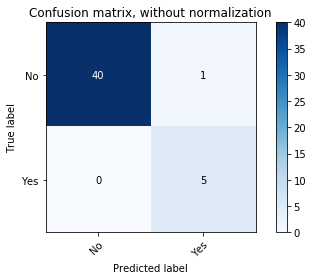

In [300]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

# The above results show the Precision and Accuracy of the 'Yes' cases is maximum with RandomForestClassifier , after taking 6 components in PCA, with StandardScaler.

# Fit the RandomForestClassifier on full data since the benchmarking study shows this model giving best results
# Lets do a k fold CV and verify the results

In [301]:
print(X_features.shape)
print(y.shape)

(229, 54)
(229,)


In [302]:
X_features = pd.DataFrame(X_features)
y = pd.DataFrame(y)

In [303]:
X_features.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [304]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_features, y], axis=1)

# separate minority and majority classes
not_choke = X[X.target==0]
choke = X[X.target==1]

In [305]:
print(len(not_choke))
print(len(choke))

204
25


In [306]:
# upsample minority
choke_upsampled = resample(choke,
                          replace=True, # sample with replacement
                          n_samples=len(not_choke), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([choke_upsampled, not_choke])

In [307]:
upsampled.target.value_counts()

1    204
0    204
Name: target, dtype: int64

In [308]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [309]:
X_train.shape

(408, 54)

In [310]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
#We define custom functions to return count of TP,TN,FP,FN for each fold
def tn(y_train, pred_train): return confusion_matrix(y_train, pred_train)[0, 0]
def fp(y_train, pred_train): return confusion_matrix(y_train, pred_train)[0, 1]
def fn(y_train, pred_train): return confusion_matrix(y_train, pred_train)[1, 0]
def tp(y_train, pred_train): return confusion_matrix(y_train, pred_train)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selector = SelectKBest(f_classif, k='all')
selector_clf = Pipeline([('selector', selector),('classifier', RandomForestClassifier(n_estimators=100))])
#selector_clf.fit(X_train, y_train)
cv_results = cross_validate(selector_clf.fit(X_train, y_train), X_train, y_train,scoring=scoring, cv=cv)

In [311]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[47 43 37 32 38]
Count of True Negatives
[35 39 45 50 43]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[0 0 0 0 1]


In [312]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(selector_clf.fit(X_train, y_train), X_train, y_train,cv=5)

In [313]:
print(cv_results['test_score'])

[0.96 0.99 1.   0.95 1.  ]


# Saving the model for predictions on validation data to be provided

In [314]:
import pickle

filename = 'finalized_model_ChokeHazard.sav'
joblib.dump(selector_clf,filename)

['finalized_model_ChokeHazard.sav']

# Loading instances

In [315]:
train_df =  train_df[:5]

In [316]:
def preprocess_text(train_df):    
    scaler_load = joblib.load("scaler_chokehazard.pkl")
    pca_load = joblib.load("pca_chokehazard.pkl")
    vectorizer_load = joblib.load("vectorizer_chokehazard.pkl")
    #x_ngram_allergens = ngram_vectorize(train_df['norm_allergens'], train_labels,n_gram_range).toarray()
    #x_ngram_allergens_m = ngram_vectorize(train_df['norm_allergens_M'], train_labels,n_gram_range).toarray()
    x_ngram_projDesc=vectorizer_load.transform(train_df['projDesc']).toarray()
    x_ngram_PDA_projName=vectorizer_load.transform(train_df['PDA_projName']).toarray()
    x_ngram_packMaterial=vectorizer_load.transform(train_df['packMaterial']).toarray() 
    x_ngram_CPD_ProdName=vectorizer_load.transform(train_df['CPD-ProdName']).toarray() 
    x_ngram_CPD_ProdName_Desc=vectorizer_load.transform(train_df['CPD-ProdName-Desc']).toarray()
    x_ngram_TCG=vectorizer_load.transform(train_df['TCG']).toarray() 
    x_ngram_labelingInstructions=vectorizer_load.transform(train_df['labelingInstructions']).toarray()
    x_ngram_mishandled=vectorizer_load.transform(train_df['mishandled']).toarray() 
    x_ngram_targetMarket=vectorizer_load.transform(train_df['targetMarket']).toarray()
    train_df = train_df.drop(['projDesc','PDA_projName','packMaterial','CPD-ProdName','TCG','labelingInstructions','mishandled','targetMarket'],axis=1)
    
    
    
    x_ngram_projDesc = scaler_load.transform(x_ngram_projDesc)
    x_ngram_PDA_projName = scaler_load.transform(x_ngram_PDA_projName)
    x_ngram_packMaterial = scaler_load.transform(x_ngram_packMaterial)
    x_ngram_CPD_ProdName = scaler_load.transform(x_ngram_CPD_ProdName)
    x_ngram_CPD_ProdName_Desc = scaler_load.transform(x_ngram_CPD_ProdName_Desc)
    x_ngram_TCG = scaler_load.transform(x_ngram_TCG)
    x_ngram_labelingInstructions = scaler_load.transform(x_ngram_labelingInstructions)
    x_ngram_mishandled = scaler_load.transform(x_ngram_mishandled)
    x_ngram_targetMarket = scaler_load.transform(x_ngram_targetMarket)
    
    x_pca_projDesc = pca_load.transform(x_ngram_projDesc)
    x_pca_PDA_projName = pca_load.transform(x_ngram_PDA_projName)
    x_pca_packMaterial = pca_load.transform(x_ngram_packMaterial)
    x_pca_CPD_ProdName = pca_load.transform(x_ngram_CPD_ProdName)
    x_pca_CPD_ProdName_Desc = pca_load.transform(x_ngram_CPD_ProdName_Desc)
    x_pca_TCG = pca_load.transform(x_ngram_TCG)
    x_pca_labelingInstructions = pca_load.transform(x_ngram_labelingInstructions)
    x_pca_mishandled = pca_load.transform(x_ngram_mishandled)
    x_pca_targetMarket = pca_load.transform(x_ngram_targetMarket)
    #x_pca_allergens_m = pca.fit_transform(x_ngram_allergens_m)
    #print(x_pca_allergens.shape)
    #print(x_pca_allergens_m.shape)
    x_train = np.concatenate((x_pca_projDesc,x_pca_PDA_projName,x_pca_packMaterial,x_pca_CPD_ProdName,x_pca_CPD_ProdName_Desc,x_pca_TCG,x_pca_labelingInstructions,x_pca_mishandled,x_pca_targetMarket),axis=1)
    print(x_train.shape)
    return x_train  

In [317]:
X_features = preprocess_text(train_df)

(5, 54)


In [318]:
pca_load = joblib.load("pca_chokehazard.pkl")
means = pca_load.mean_ 

In [319]:
print(means)

[ 2.33e-08  2.33e-08 -1.20e-07 -1.20e-07 -5.93e-08 -1.20e-07 -3.68e-08
  1.06e-07  4.93e-08  9.16e-08  2.33e-08 -4.62e-08  5.08e-09 -2.72e-08
 -2.72e-08 -5.93e-08 -5.93e-08  5.54e-07  5.54e-07 -3.08e-07  1.06e-07
  5.08e-09 -5.93e-08  4.93e-08  4.93e-08  5.54e-07  5.54e-07 -8.33e-09
  5.54e-07  5.54e-07 -3.68e-08 -3.68e-08  8.83e-08 -3.68e-08  2.33e-08
 -4.66e-08 -1.82e-07 -3.08e-07 -5.29e-07  3.24e-08 -6.25e-09  5.54e-07
  5.54e-07 -2.34e-07  1.18e-07  1.51e-07  5.62e-08 -1.24e-07  4.93e-08
  5.54e-07  5.08e-09  5.08e-09 -5.93e-08 -5.93e-08 -1.20e-07 -1.20e-07
  1.91e-08 -4.62e-08  5.08e-09 -1.88e-07  1.51e-07 -5.93e-08  5.08e-09
 -8.33e-09 -3.08e-07  1.51e-07  1.51e-07  5.08e-09  5.08e-09 -5.93e-08
 -5.93e-08]


In [320]:
from sklearn.utils.extmath import fast_dot
td = x_ngram_projDesc - means[:6]
tdd = fast_dot(td, pca.components_.T)

NameError: name 'x_ngram_projDesc' is not defined